# Packages

In [1]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from datetime import datetime
import rootutils
from burned_embedder.data import load_s1, load_s2, find_closest_timestamps
import ipywidgets as widgets
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Setup paths
import rootutils
root_path = rootutils.find_root()


# FUnctions

In [13]:
def load_embeddings_data(embeddings_dir, mode='combined'):
    """Load embeddings, dates, ndvi for a specific mode"""
    embeddings = np.load(embeddings_dir / f"{mode}_embeddings.npy")
    dates = np.load(embeddings_dir / f"{mode}_dates.npy")
    ndvi = np.load(embeddings_dir / f"{mode}_ndvi.npy")
    metadata = np.load(embeddings_dir / "metadata.npy", allow_pickle=True).item()
    
    return embeddings, dates, ndvi, metadata


def create_rgb_image(da_s2_t):
    """Create RGB image from Sentinel-2 data"""
    try:
        red = da_s2_t.sel(band='B04').values
        green = da_s2_t.sel(band='B03').values  
        blue = da_s2_t.sel(band='B02').values
        
        rgb = np.stack([red, green, blue], axis=-1)
        rgb = np.clip(rgb, 0, 3000) / 3000.0
        
        return rgb
    except Exception as e:
        print(f"Error creating RGB: {e}")
        return None

def create_interactive_time_series_plot(da_s2, saved_dates, embeddings_pca, 
                                       timeseries_df, fire_date, mode='embeddings'):
    """Create interactive time series plot with clickable points that show RGB images."""
    
    # Setup data
    timeseries_df = timeseries_df.copy().reset_index(drop=True)
    timeseries_df['is_post_fire'] = timeseries_df['date'] > fire_date
    fire_day_of_year = fire_date.timetuple().tm_yday
    
    # Convert saved dates to match S2 timestamps for filtering
    saved_dates_pd = pd.to_datetime(saved_dates)
    
    # Setup matplotlib figure for RGB display
    plt.ioff()
    fig_rgb, ax_rgb = plt.subplots(figsize=(8, 8))
    
    def show_rgb_for_index(idx):
        """Show RGB image for a specific index"""
        if idx >= len(saved_dates_pd):
            print(f"Index {idx} out of range")
            return
        
        # Find matching S2 timestamp
        target_date = saved_dates_pd[idx]
        s2_times = pd.to_datetime(da_s2.time.values)
        time_diffs = abs(s2_times - target_date)
        s2_idx = time_diffs.argmin()
        
        da_s2_t = da_s2.isel(time=s2_idx)
        rgb_image = create_rgb_image(da_s2_t)
        
        if rgb_image is not None:
            ax_rgb.clear()
            ax_rgb.imshow(rgb_image)
            ax_rgb.set_title(f"RGB Image - {timeseries_df.loc[idx, 'date'].strftime('%Y-%m-%d')}\n"
                           f"PC1: {embeddings_pca[idx, 0]:.3f}, NDVI: {timeseries_df.loc[idx, 'ndvi']:.3f}")
            ax_rgb.axis('off')
            fig_rgb.canvas.draw()
            display(fig_rgb)
            clear_output(wait=True)
        else:
            print(f"Could not create RGB image for index {idx}")
    
    # Create slider
    index_slider = widgets.IntSlider(
        min=0, max=len(embeddings_pca)-1, step=1, value=0, description='Image Index:'
    )
    
    # Helper function to create scatter trace
    def create_scatter_trace(df_subset, name, marker_config):
        return go.Scatter(
            x=df_subset['day_of_year'],
            y=df_subset['pc1'],
            mode='markers',
            marker=marker_config,
            text=[f"Date: {row['date'].strftime('%Y-%m-%d')}<br>PC1: {row['pc1']:.3f}<br>NDVI: {row['ndvi']:.3f}<br>Index: {row['index']}" 
                  for _, row in df_subset.iterrows()],
            hovertemplate='%{text}<br>Click to see RGB image<extra></extra>',
            name=name,
            customdata=df_subset['index'].values
        )
    
    # Build plotly figure
    fig = go.Figure()
    
    pre_fire_df = timeseries_df[~timeseries_df['is_post_fire']].reset_index(drop=True)
    post_fire_df = timeseries_df[timeseries_df['is_post_fire']].reset_index(drop=True)
    
    # Add traces
    if len(pre_fire_df) > 0:
        pre_fire_marker = dict(color=pre_fire_df['year'], colorscale='Viridis', 
                              size=8, opacity=0.7, showscale=True, colorbar=dict(title="Year"))
        fig.add_trace(create_scatter_trace(pre_fire_df, 'Pre-fire', pre_fire_marker))
    
    if len(post_fire_df) > 0:
        post_fire_marker = dict(color='red', size=10, opacity=0.9, symbol='diamond')
        fig.add_trace(create_scatter_trace(post_fire_df, 'Post-fire', post_fire_marker))
    
    # Add fire date line and layout
    fig.add_vline(x=fire_day_of_year, line_dash="dash", line_color="red", 
                  annotation_text=f"Fire: {fire_date.strftime('%Y-%m-%d')}")
    
    fig.update_layout(
        title=f'{mode.upper()}: PC1 vs Day of Year (Click points to update slider)',
        xaxis_title='Day of Year', yaxis_title='PC1',
        width=1000, height=600, hovermode='closest'
    )
    
    # Setup interactivity
    fig_widget = go.FigureWidget(fig)
    
    def handle_click(trace, points, state):
        if points.point_inds:
            idx = trace.customdata[points.point_inds[0]]
            print(f"Clicked point {idx}: {timeseries_df.loc[idx, 'date'].strftime('%Y-%m-%d')}")
            index_slider.value = idx
    
    # Add click handlers
    for trace in fig_widget.data:
        if hasattr(trace, 'customdata') and trace.customdata is not None:
            trace.on_click(handle_click)
    
    # Display
    display(fig_widget)
    print("\nClick on points to update the slider below, or use the slider manually")
    
    interactive_widget = widgets.interact(show_rgb_for_index, idx=index_slider)
    return fig_widget, interactive_widget

# Analysis

In [14]:
# Load satellite data and embeddings
embeddings_dir = root_path / "data" / "embeddings" / "dueben_fire_notime_2_terrafm"

# Choose mode to visualize
mode = 's2_only'  # or 's1_only', 's2_only'

# Load results
embeddings, dates, ndvi, metadata = load_embeddings_data(embeddings_dir=embeddings_dir, mode=mode)

# if da_s2 does not exist, load it
if 'da_s2' not in locals():
    da_s2 = load_s2(lat=metadata['lat'], lon=metadata['lon'],
                     start_date=metadata['start_date'], end_date=metadata['end_date'],
                     bands=["B02","B03","B04"])  # Load only RGB bands for faster processing


In [21]:
# Convert dates to pandas datetime and perform PCA
dates_pd = pd.to_datetime(dates)
pca = PCA()
embeddings_pca = pca.fit_transform(embeddings)

print(f"Loaded {len(embeddings)} embeddings for {mode} mode")
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.3f} of variance")

# Create dataframe for plotting
timeseries_df = pd.DataFrame({
    'date': dates_pd,
    'pc1': embeddings_pca[:, 0],
    'ndvi': ndvi,
    'day_of_year': dates_pd.dayofyear,
    'year': dates_pd.year,
    'index': range(len(embeddings))
})

# Create interactive plot
fig_widget, interactive_widget = create_interactive_time_series_plot(
    da_s2=da_s2,
    saved_dates=dates,
    embeddings_pca=embeddings_pca,
    timeseries_df=timeseries_df,
    fire_date=metadata['fire_date'],
    mode=mode
)

Loaded 107 embeddings for s2_only mode
PC1 explains 0.232 of variance


FigureWidget({
    'data': [{'customdata': {'bdata': ('AAECAwQFBgcICQoLDA0ODxAREhMUFR' ... 'NUVVZXWFlaW1xdXl9gYWJjZGVmZ2hp'),
                             'dtype': 'i1'},
              'hovertemplate': '%{text}<br>Click to see RGB image<extra></extra>',
              'marker': {'color': {'bdata': ('4QcAAOEHAADhBwAA4QcAAOEHAADiBw' ... 'cAAOkHAADpBwAA6QcAAOkHAADpBwAA'),
                                   'dtype': 'i4'},
                         'colorbar': {'title': {'text': 'Year'}},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777


Click on points to update the slider below, or use the slider manually


interactive(children=(IntSlider(value=0, description='Image Index:', max=106), Output()), _dom_classes=('widge…

In [17]:
from burned_embedder.distance_metrics import print_similarity_analysis

In [18]:
print_similarity_analysis(embeddings, dates_pd, metadata['fire_date'], metric="cosine")

=== Similarity Analysis using COSINE distance ===

Centroid distance (pre vs post-fire): 0.0933
Average within pre-fire distances: 0.1588
Average within post-fire distances: 0.0046
Average cross-group distances: 0.1687

Top 5 most anomalous timepoints:
  2017-01-27: score = 0.3829
  2018-05-29: score = 0.3515
  2017-02-13: score = 0.3104
  2017-02-16: score = 0.2831
  2023-08-11: score = 0.2586


({'pre_fire_centroid': array([ 1.88957274e+00, -4.49635059e-01,  1.08259463e+00,  9.92902935e-01,
          2.96515197e-01, -9.04355586e-01,  1.14450598e+00,  1.55242252e+00,
         -2.02623057e+00, -1.51048350e+00, -3.74053985e-01, -4.10528958e-01,
          2.43870560e-02,  3.00668657e-01, -4.45615023e-01,  9.49762404e-01,
          2.41999686e-01, -1.59252214e+00, -1.85641479e+00, -8.67911100e-01,
         -1.36667418e+00, -4.55241978e-01,  6.82921588e-01,  4.00151253e-01,
         -1.58111429e+00,  1.71906984e+00,  6.31457090e-01, -1.12412810e+00,
          3.96803617e-02,  3.60889375e-01, -1.98590803e+00,  8.66936803e-01,
         -1.25493300e+00,  2.63249755e-01, -5.48175760e-02,  8.94734204e-01,
         -3.19343626e-01, -4.21272069e-01,  1.93030608e+00, -2.46011809e-01,
          1.05731487e+00, -1.25870836e+00,  1.41562331e+00,  1.08147073e+00,
          3.46012414e-01,  4.99936849e-01, -8.46170485e-01, -6.43045545e-01,
          1.76834774e+00, -5.70361674e-01,  2.78041387e

In [19]:
from burned_embedder.analysis import analyze_fire_detection

Analyzing fire detection for s2_only mode...
Embedding shape: (107, 768)


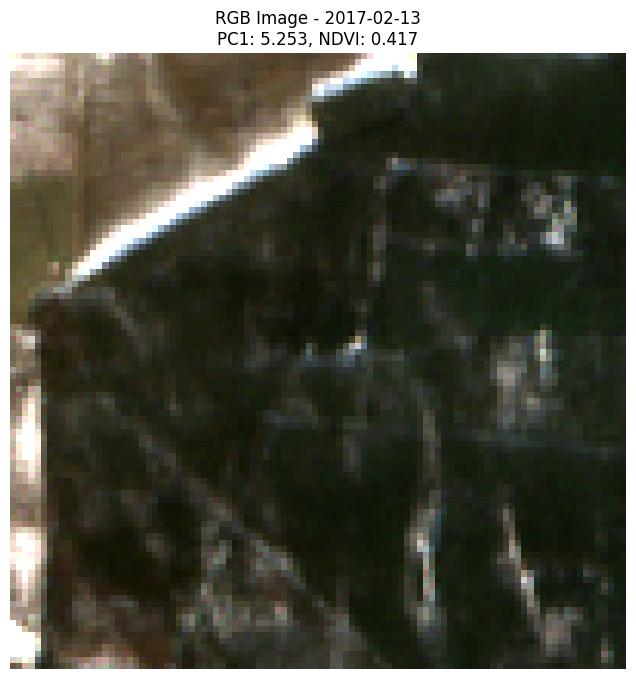

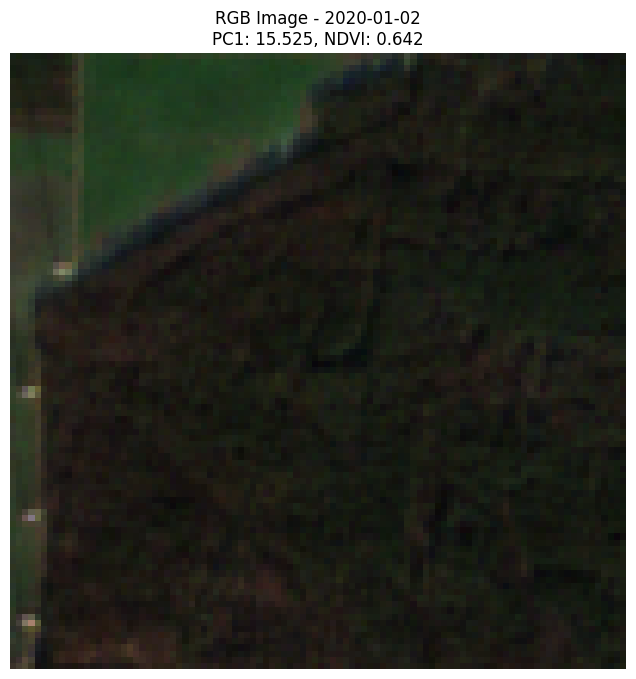

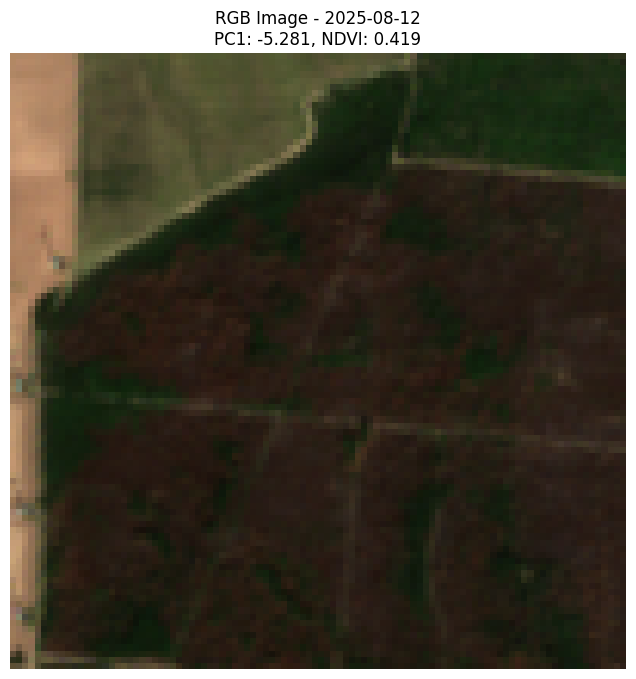

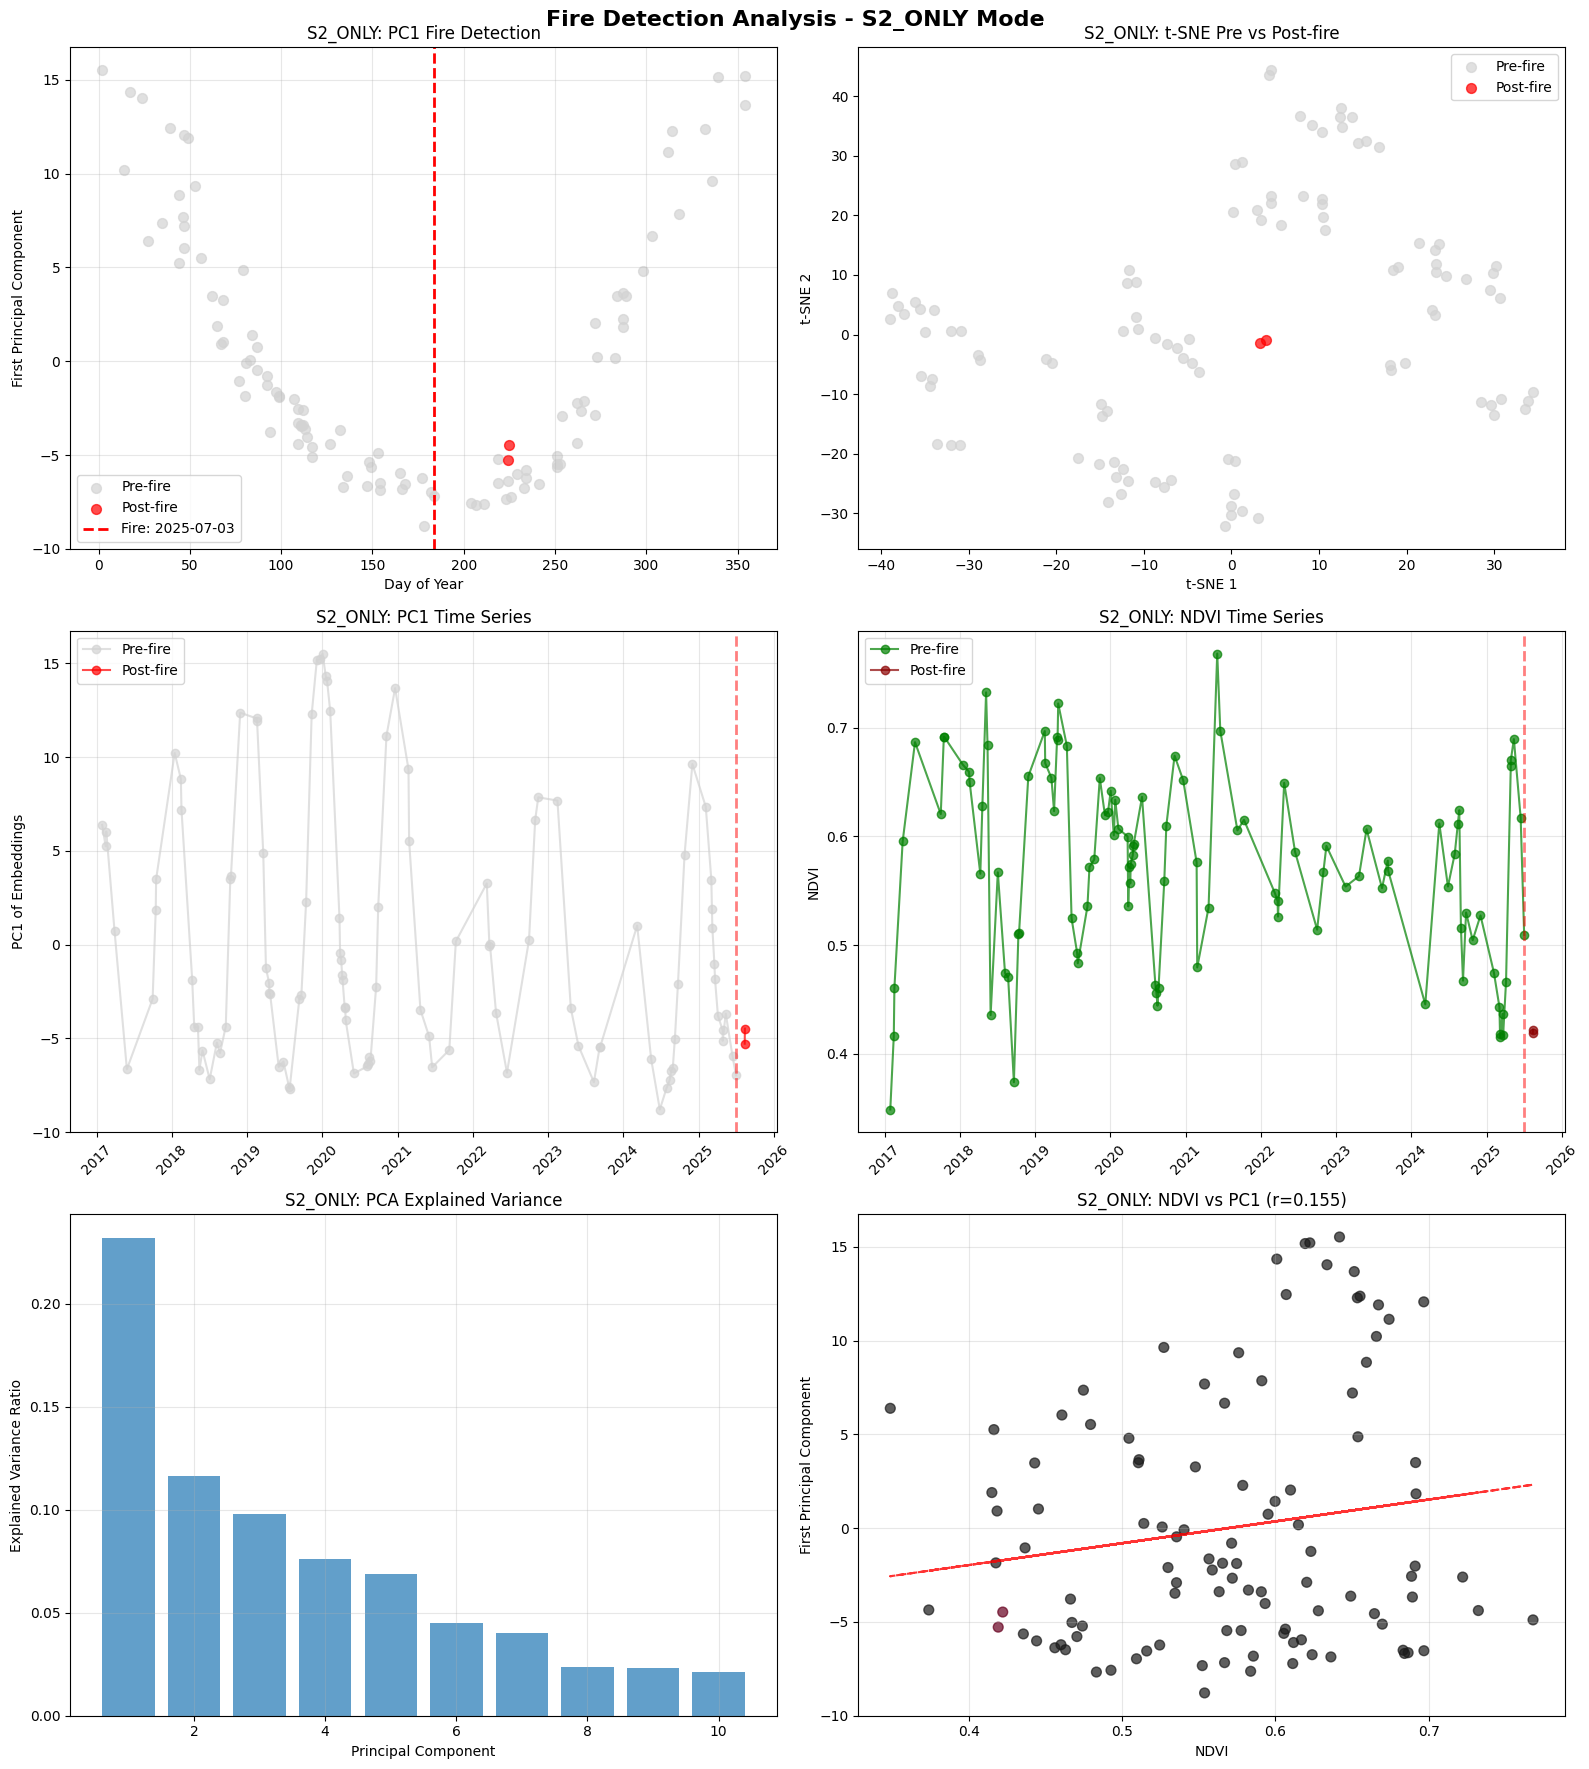

/net/home/lmaecker/own_projects/burned_embedder/burned_embedder/analysis.py:177: OptimizeWarning:

Covariance of the parameters could not be estimated



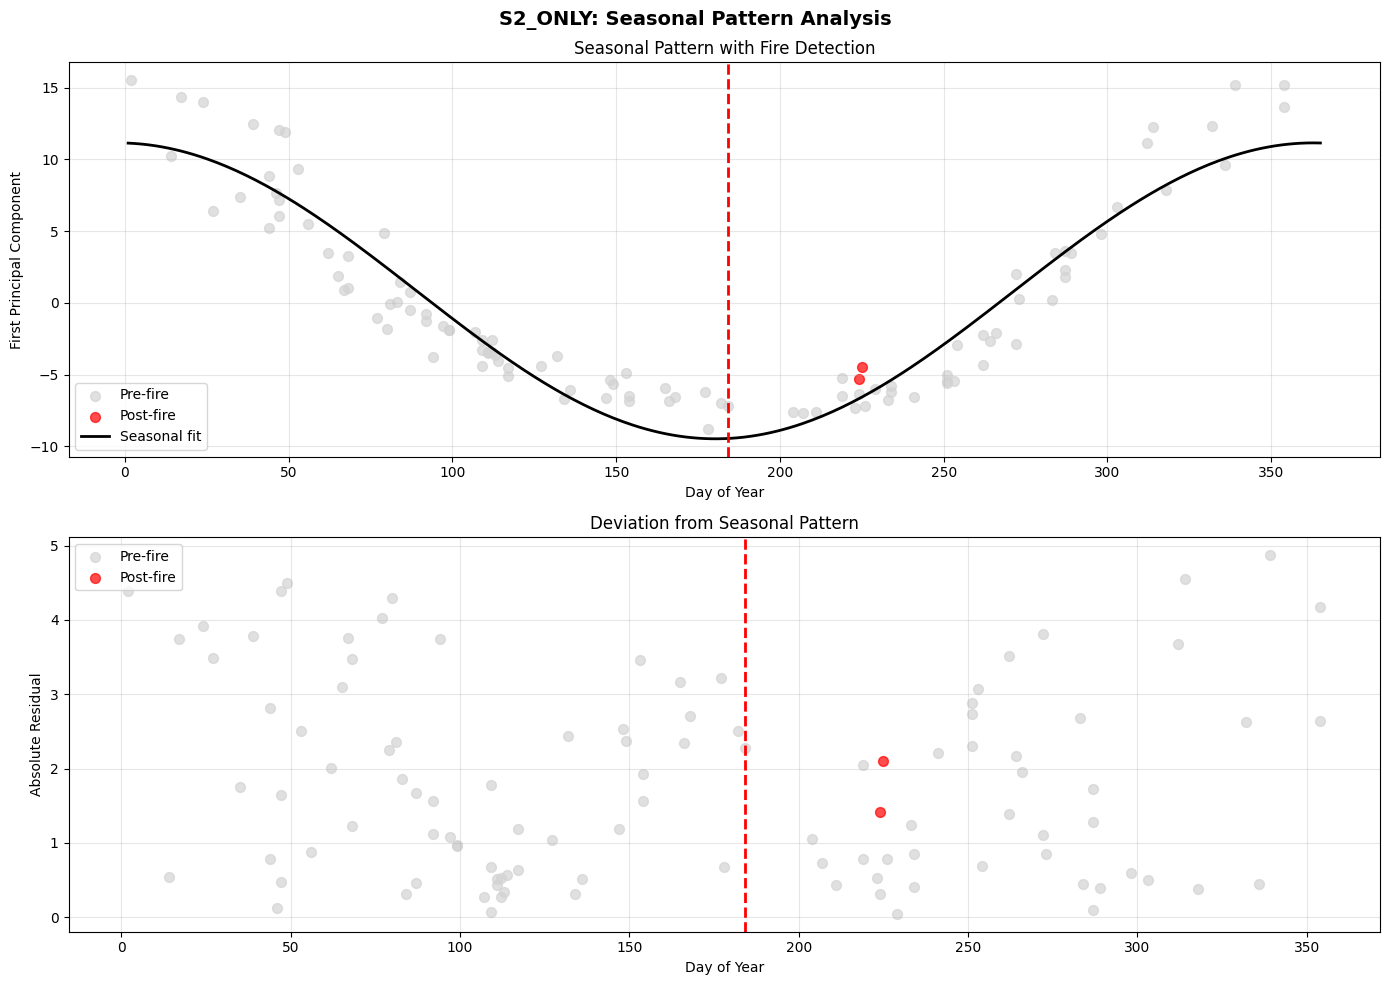


=== S2_ONLY FIRE DETECTION ANALYSIS ===
Embedding dimension: 768
PC1 variance explained: 0.232
Pre-fire PC1: 0.093 ± 6.676
Post-fire PC1: -4.878 ± 0.403
Pre-fire NDVI: 0.572 ± 0.087
Post-fire NDVI: 0.421 ± 0.001
PC1 t-test p-value: 0.2993
NDVI t-test p-value: 0.0166


In [20]:
results={}

save_dir = root_path / "reports" / "figures" / "dueben_fire_analysis_notime_2_terrafm"

results[mode] = analyze_fire_detection(embeddings, dates, ndvi, mode, save_dir, metadata['fire_date'])


Analyzing fire detection for s2_only mode...
Embedding shape: (107, 768)


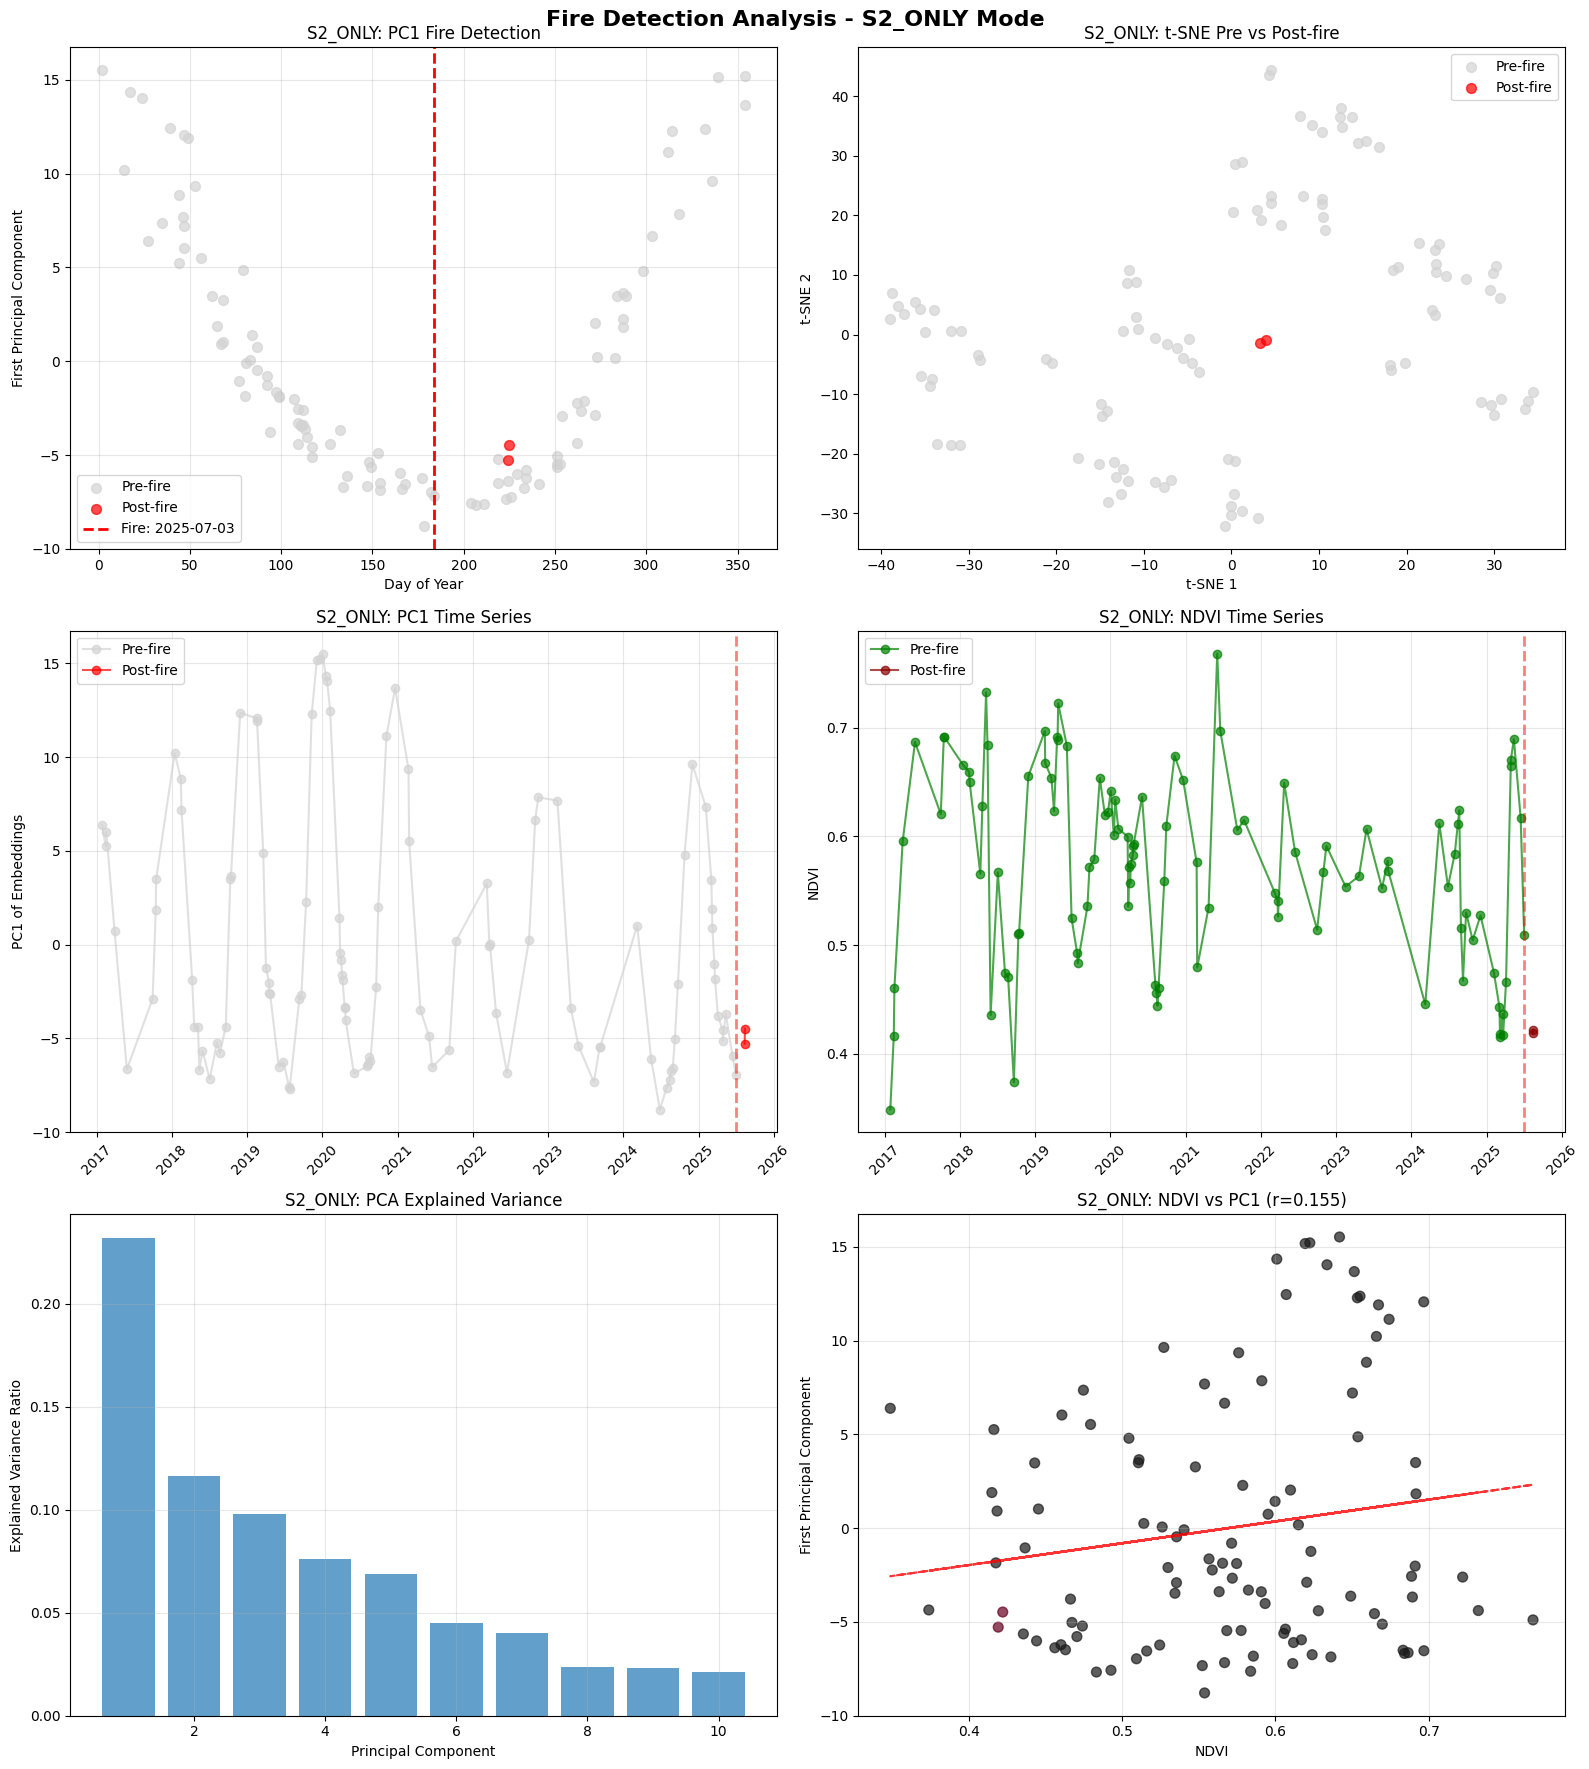

/net/home/lmaecker/own_projects/burned_embedder/burned_embedder/analysis.py:177: OptimizeWarning:

Covariance of the parameters could not be estimated



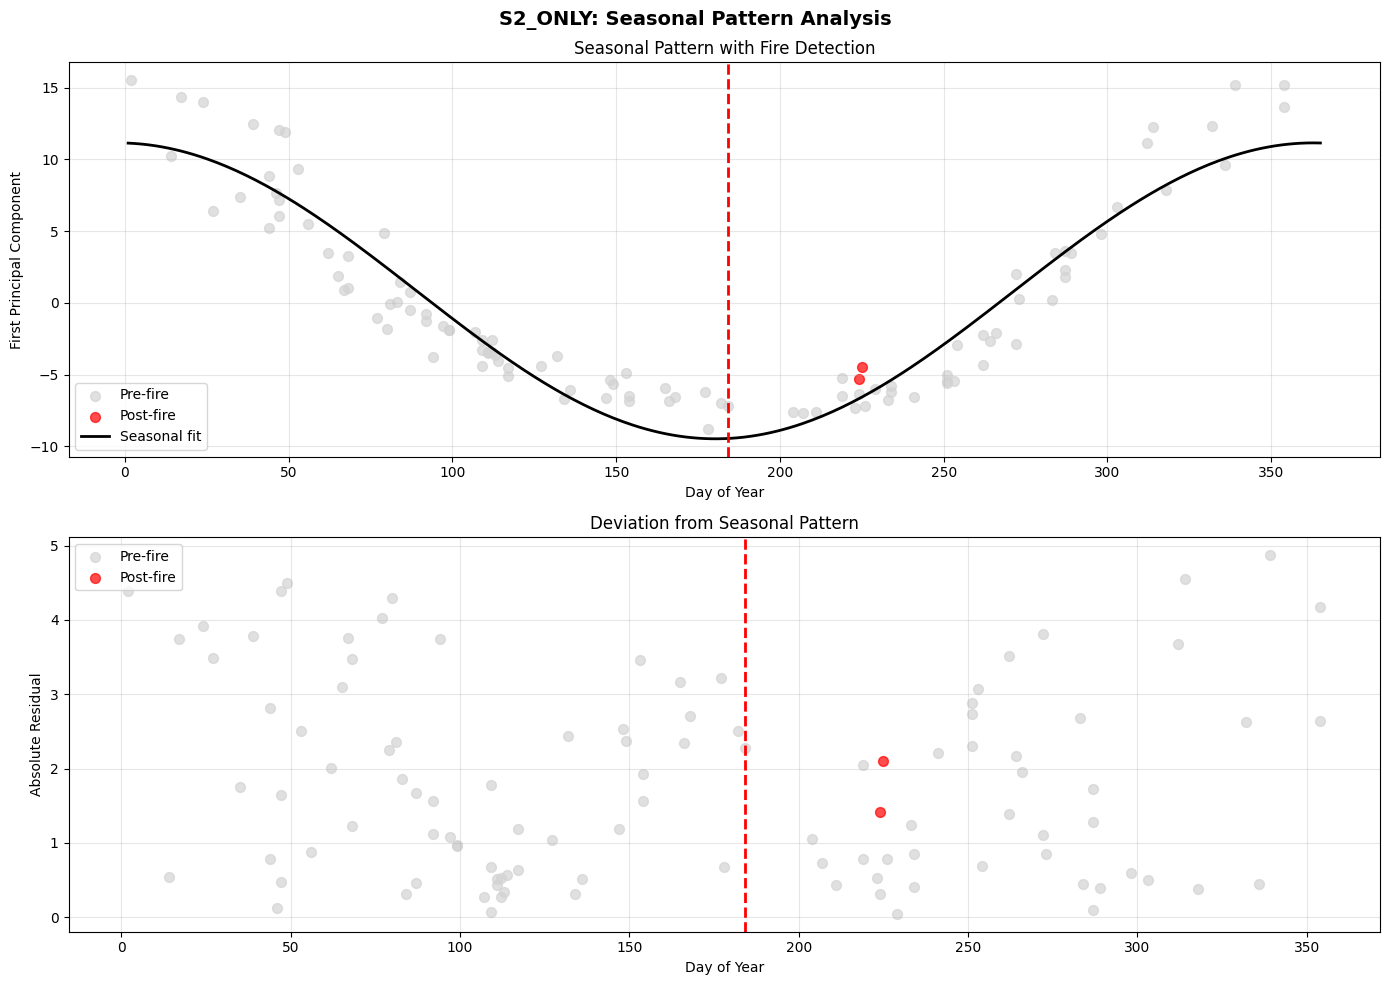


=== S2_ONLY FIRE DETECTION ANALYSIS ===
Embedding dimension: 768
PC1 variance explained: 0.232
Pre-fire PC1: 0.093 ± 6.676
Post-fire PC1: -4.878 ± 0.403
Pre-fire NDVI: 0.572 ± 0.087
Post-fire NDVI: 0.421 ± 0.001
PC1 t-test p-value: 0.2993
NDVI t-test p-value: 0.0166


In [ ]:
results={}

save_dir = root_path / "reports" / "figures" / "dueben_fire_analysis_notime_2_terrafm"

results[mode] = analyze_fire_detection(embeddings, dates, ndvi, mode, save_dir, metadata['fire_date'])
